# Examining Telemarketing Data

Please see <code>db.py</code> and <code>processing.py</code> for the implentation of database and processing related utilities used in this notebook.

In [4]:
#database access functions
from db import Database
#general processing and data cleaning functions
import processing as proc
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import sklearn

logger = proc.setupLog()
figureCount = 0
records = Database("bank_data")

In [5]:
numPeople = records.getSize('people')
numPeopleAdditional = records.getSize('people_additional')
peopleOut = records.getEntriesByField('people',0,numPeople,'y')
peopleAdditionalOut = records.getEntriesByField('people_additional',0,numPeopleAdditional,'y')

### Taking a look
We begin by checking the frequency of the target, <code>y</code>, which denotes whether or not a purchase was made.

There are two seperate datasets here, both have the same target, with one having a few extra features, they are primarily economic indicators at the time of contact.  The datasets were taken from UCI's machine learning repository linked [here](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

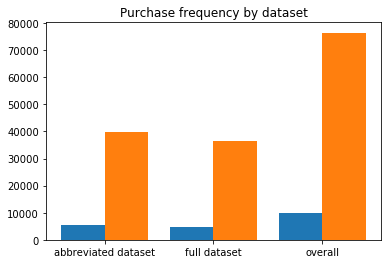

In the abbreviated dataset a purchase occured 11.70% of the time.
In the full dataset a purchase occured 11.27% of the time.
In the combined dataset a purchase occured 11.49% of the time.


In [6]:
#print out buying frequency
peopleBuy = 0
for char in peopleOut:
    if char == 'Y': peopleBuy+=1
peopleAdditionalBuy = 0
for char in peopleAdditionalOut:
    if char == 'Y': peopleAdditionalBuy+=1

buys = (peopleBuy,peopleAdditionalBuy,peopleBuy+peopleAdditionalBuy)
notBuys = (numPeople-buys[0],numPeopleAdditional-buys[1],numPeople+numPeopleAdditional-buys[2])

ind = [ i for i in range(3)]
width = .4
plt.figure(figureCount)
figureCount+=1
plt.bar(ind,buys,width,label= 'Purchase')
plt.bar([item+width for item in ind],notBuys,width,label='No Purchase')
plt.title('Purchase frequency by dataset')
plt.xticks([item+width/2 for item in ind],('abbreviated dataset','full dataset', 'overall'))
plt.show()

print("In the abbreviated dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[0])/float(numPeople) )*100 ) )
print("In the full dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[1])/float(numPeopleAdditional) )*100 ) )
print("In the combined dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[2])/float(numPeople+numPeopleAdditional) )*100 ) )


### Getting our dataset ready for processing
The dataset has been extracted from csv, translated for efficient storage (strings mapped to characters etc.) and loaded into a MySQL database.

Below is a few of the fetched SQL entries and human-readable dataframes lines.  For completeness, a single final encoding of the ready-for-work numpy vector is also displayed.

*Note: We remove the <code>duration</code> field as reccomended in the dataset posting.  See the link above for more information.*

In [7]:
#get data dictionaries for processing
peopleMap, peopleAdditionalMap = records.getMaps()
#sql entries
line = records.getEntries('people',0,numPeople)
print('First 5 of the sql entries:')
for i in range(5):
    print(line[i])
#translate to human-readable dataframe (similar to original csv)
df = proc.getDataFrame(line,peopleMap)
print('\n\nHead of the dataframe:')
print(df.head())

#see validate for more details, basically ensures all categories accounted for properly
proc.validate(df,peopleMap)

vec = proc.getOneHot(df,peopleMap,False)
#duration is not known until outcome is known
#see dataset documentation for more info
vec = vec.drop('duration',axis=1)
dataOneHot = vec.to_numpy(dtype=np.float64)

print('\n\nFinally, here is a single vector ready for processing:')
print(dataOneHot[0])


lineA = records.getEntries('people_additional',0,numPeopleAdditional)
dfa = proc.getDataFrame(lineA,peopleAdditionalMap)
proc.validate(dfa,peopleAdditionalMap)
vecA = proc.getOneHot(dfa,peopleAdditionalMap,False)
vecA = vecA.drop('duration',axis=1)


#rand generator
randomGenr = np.random.default_rng()

#get cols
colTitles = vec.columns
colTitlesA = vecA.columns
#get processing array

dataOneHotA = vecA.to_numpy(dtype=np.float64)

First 5 of the sql entries:
(58, 'M', 'M', 'T', 'N', 2143, 'Y', 'N', '?', 5, 5, 261, 1, -1, 0, '?', 'N')
(44, 'T', 'S', 'S', 'N', 29, 'Y', 'N', '?', 5, 5, 151, 1, -1, 0, '?', 'N')
(33, 'E', 'M', 'S', 'N', 2, 'Y', 'Y', '?', 5, 5, 76, 1, -1, 0, '?', 'N')
(47, 'B', 'M', '?', 'N', 1506, 'Y', 'N', '?', 5, 5, 92, 1, -1, 0, '?', 'N')
(33, '?', 'S', '?', 'N', 1, 'N', 'N', '?', 5, 5, 198, 1, -1, 0, '?', 'N')


Head of the dataframe:
   age           job  marital  education isDefault  balance housing loan  \
0   58    management  married   tertiary        no     2143     yes   no   
1   44    technician   single  secondary        no       29     yes   no   
2   33  entrepreneur  married  secondary        no        2     yes  yes   
3   47   blue-collar  married    unknown        no     1506     yes   no   
4   33       unknown   single    unknown        no        1      no   no   

   contact  day  month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5      5       261        

### Running the model

After running a small number of different models, this one turns out to be particularily good at predicting the target.  It is not overwhelmingly suprising that Random Forest turns out to be a great performer, as the dataset is primarily composed of features data.

In addition to training and testing on [<code>sklearn.ensemble.RandomForestClassifier</code>](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest%20classifier#sklearn.ensemble.RandomForestClassifier), [<code>sklearn.inspection.permutation_importance</code>](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html?highlight=permutation%20importance#sklearn.inspection.permutation_importance) is run on the model so that we can gain insight into which features are most important in making the predictions.

*Resulting vectors are then saved for later processing.*

In [11]:
numTrees = 1000
numRuns =  5
#create directories for results
Path("./np").mkdir(exist_ok=True)
#for true values
Path("./np/actual").mkdir(exist_ok=True)
#for random forest output and related
Path("./np/rafo").mkdir(exist_ok=True)
for i in range(numRuns):
    print('trial: {}'.format(i))
    
    #generate models
    treeModel = RandomForestClassifier(n_estimators=numTrees)
    treeModelA = RandomForestClassifier(n_estimators=numTrees)
    

    #get datasets 
    dataP = dataOneHot
    dataA = dataOneHotA
        
    #shuffle data
    randomGenr.shuffle(dataP)
    randomGenr.shuffle(dataA)
    
    #extract features, set float
    features = dataP[:,:-1].astype(np.float64)
    featuresA = dataA[:,:-1].astype(np.float64)
    
    #extract labels
    labels = dataP[:,-1]
    labelsA = dataA[:,-1]
    

    #get ~10% of indices as random choice WITHOUT replacement for test
    testIndices = randomGenr.choice(len(labels),size=int(len(labels)*.1),replace=False)
    testIndicesA = randomGenr.choice(len(labelsA),size=int(len(labelsA)*.1),replace=False)
    
    #take test items
    testLabels = np.take(labels,testIndices)
    testFeatures = np.take(features,testIndices,axis=0)
    testLabelsA = np.take(labelsA,testIndicesA)
    testFeaturesA = np.take(featuresA,testIndicesA,axis=0)

    #remove test items
    trainLabels = np.delete(labels,testIndices)
    trainFeatures = np.delete(features,testIndices,axis=0)
    trainLabelsA = np.delete(labelsA,testIndicesA)
    trainFeaturesA = np.delete(featuresA,testIndicesA,axis=0)

    #fit models
    treeModel.fit(trainFeatures,trainLabels)
    treeModelA.fit(trainFeaturesA,trainLabelsA)
 
    #get predictions
    treePredictions = treeModel.predict(testFeatures)
    treePredictionsA = treeModelA.predict(testFeaturesA)
    
    #get model probability score for predictions
    treeProbs = treeModel.predict_proba(testFeatures)
    treeProbsA = treeModel.predict_proba(testFeatures)
    
    #get feature importance 
    bunch = permutation_importance(treeModel, testFeatures, testLabels, n_repeats=10)
    bunchA = permutation_importance(treeModelA, testFeaturesA, testLabelsA, n_repeats=10)
   


    #Save records for later processing
    np.save('./np/actual/actual_{}'.format(i),testLabels)
    np.save('./np/actual/actual_add_{}'.format(i),testLabelsA)
    
    np.save('./np/rafo/prediction_{}_{}'.format(i,numTrees),treePredictions)
    np.save('./np/rafo/tree_proba_{}_{}'.format(i,numTrees),treeProbs)
    
    np.save('./np/rafo/prediction_add_{}_{}'.format(i,numTrees),treePredictionsA)
    np.save('./np/rafo/tree_proba_add_{}_{}'.format(i,numTrees),treeProbsA)
    
    for key in bunch.keys():
        np.save('./np/rafo/perm_import_{}_{}'.format(i,key),bunch[key])
        np.save('./np/rafo/perm_import_add_{}_{}'.format(i,key),bunchA[key])
        
print('done')

    

trial: 0
trial: 1
trial: 2
trial: 3
trial: 4
done


### Checking results
We now read in results of the model above, tally up correct and incorrect predictions, and record the probability assigned to each prediction by the model.

In [12]:
forestPred = np.array([])
forestProb = np.array([])
actual = np.array([])
forestPredA = np.array([])
forestProbA = np.array([])
actualA = np.array([])
bunches = np.array([])
bunchesA = np.array([])


for i in range(numRuns):

    if(i==0):
        actual = [np.load('./np/actual/actual_{}.npy'.format(i))]
        forestPred = [np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))]
        forestProb = [np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))]
        
        actualA = [np.load('./np/actual/actual_add_{}.npy'.format(i))]
        forestPredA = [np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))]
        forestProbA = [np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))]

    else:
        actual = np.append(actual,[np.load('./np/actual/actual_{}.npy'.format(i))],axis=0)
        forestPred = np.append(forestPred,[np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProb = np.append(forestProb,[np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))],axis=0)
        
        actualA = np.append(actualA,[np.load('./np/actual/actual_add_{}.npy'.format(i))],axis=0)
        forestPredA = np.append(forestPredA,[np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProbA = np.append(forestProbA,[np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))],axis=0)
    bunch = dict()
    bunchA = dict()
    for key in ['importances','importances_mean','importances_std']:
        bunch[key] = np.load('/Users/jake/proj/tele_pred/np/rafo/perm_import_{}_{}.npy'.format(i,key))
        bunchA[key] = np.load('/Users/jake/proj/tele_pred/np/rafo/perm_import_add_{}_{}.npy'.format(i,key))
    bunches = np.append(bunches,bunch)
    bunchesA = np.append(bunchesA,bunchA)
    

corrects = []
wrongs = []
for i in range(2):
    c = []
    #this is the probability(y=1)
    w = []
    for ac,fo,pr in zip(actual,forestPred,forestProb):
        #[trueNegative,truePositive,averageProb]
        correct = [0,0,0]
        #[falseNegative,falsePositive,averageProb]
        wrong = [0,0,0]
        for a,f,p in zip(ac,fo,pr):
            if a == f:
                correct[int(a)]+=1
                correct[2]+=p[int(f)]
            else:
                wrong[int(a)]+=1
                wrong[2]+=p[int(f)]
        
        correct[2] = correct[2]/(correct[0]+correct[1])
        wrong[2] = wrong[2]/(wrong[0]+wrong[1])
        c.append(correct)
        w.append(wrong)
    corrects.append(c)
    wrongs.append(w)

Here we record some of the information in a log file for safe keeping.

In [10]:
logger.info('numTrees={} results:'.format(numTrees))
for co,wr in zip(corrects,wrongs):
    i=0
    for c,w in zip(co,wr):
        if i==0:
            logger.info("RUN NUMBER: {}, number of trees: {}, standard feature set".format(i,numTrees))
        else:
            logger.info("RUN NUMBER: {}, number of trees: {}, extended feature set".format(i,numTrees))
    
        logger.info("{} TRUE POSITIVES".format(c[1]))
        logger.info("{} TRUE NEGATIVES".format(c[0]))
        logger.info("{} FALSE POSITIVES".format(w[0]))
        logger.info("{} FALSE NEGATIVES".format(w[1]))
        logger.info('correct {}% of the time with average confidence={}'.format((100*(c[0]+c[1])/(w[0]+w[1]+c[0]+c[1])),c[2]))
        logger.info('wrong {}% of the time with average confidence={}'.format((100*(w[0]+w[1])/(w[0]+w[1]+c[0]+c[1])),w[2]))
        logger.info('\n---')
        i+=1
   
        

'\nlogger.info(\'Duration feature has been removed for these runs:\')\nfor co,wr in zip(corrects,wrongs):\n    i=0\n    for c,w in zip(co,wr):\n        if i==0:\n            logger.info("RUN NUMBER: {}, number of trees: {}, standard feature set".format(i,numTrees))\n        else:\n            logger.info("RUN NUMBER: {}, number of trees: {}, extended feature set".format(i,numTrees))\n    \n        logger.info("{} TRUE POSITIVES".format(c[1]))\n        logger.info("{} TRUE NEGATIVES".format(c[0]))\n        logger.info("{} FALSE POSITIVES".format(w[0]))\n        logger.info("{} FALSE NEGATIVES".format(w[1]))\n        logger.info(\'correct {}% of the time with average confidence={}\'.format((100*(c[0]+c[1])/(w[0]+w[1]+c[0]+c[1])),c[2]))\n        logger.info(\'wrong {}% of the time with average confidence={}\'.format((100*(w[0]+w[1])/(w[0]+w[1]+c[0]+c[1])),w[2]))\n        logger.info(\'\n---\')\n        i+=1\n '

	Feature importance for abbreviated dataset:


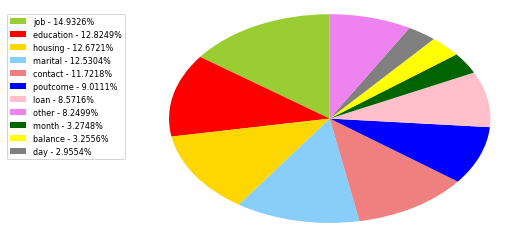

other feautures :
age - 2.8193%
campaign - 2.3531%
isDefault - 2.2505%
previous - 0.6232%
pdays - 0.2037%


	Feature importance for dataset with all features:


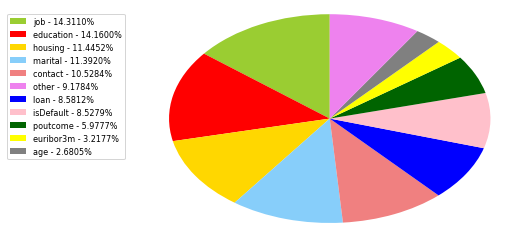

other feautures :
campaign - 2.1185%
day_of_week - 2.0924%
nr.employed - 1.1050%
emp.var.rate - 1.0774%
cons.price.idx - 0.8567%
cons.conf.idx - 0.7195%
month - 0.7144%
previous - 0.3122%
pdays - 0.1822%


In [11]:
cols = colTitles[:-1]
colsA = colTitlesA[:-1]

#returns labels,means,rest - labels and means are top~90% of importances, and rest is rest
result = proc.processImportance(peopleMap,cols,bunches[0])
print('\tFeature importance for abbreviated dataset:')
proc.pie(result[0],result[1],result[2],figureCount)
figureCount+=1
print('\n\n\tFeature importance for dataset with all features:')
resultA = proc.processImportance(peopleAdditionalMap,colsA,bunchesA[0])
proc.pie(resultA[0],resultA[1],resultA[2],figureCount)
figureCount+=1





In [12]:
#an attempt to calcualte covariences directly resulted in kernel failure likely related to
#virtual/swap memory constraints, could even be due to firefox??
#below is a funky way of getting around it, making use of the fact that we dont actually care
#about the entire matrix, but only the covariences which involve the label
features = dataOneHot[:,:-1]
labels = dataOneHot[:,-1]

print('begin epic 🐏 saving procedure 😳')
for feature,data in zip(cols,features.T):
        pairData = np.array([labels,data])
        #print(pairData.shape)
        np.save('./np/cov/{}'.format(feature),pairData)
        cov = np.cov(pairData)
        np.save('./np/cov/{}_cov'.format(feature),cov)
print('done with abbrev')

features = dataOneHotA[:,:-1]
labels = dataOneHotA[:,-1]
for feature,data in zip(colsA,features.T):
        pairData = np.array([labels,data])
        np.save('./np/covA/{}'.format(feature),pairData)
        cov = np.cov(pairData)
        np.save('./np/covA/{}_cov'.format(feature),cov)
print('epicness complete 😂')

begin epic 🐏 saving procedure 😳
done with abbrev
epicness complete 😂


In [13]:
#correlation with output variable

#correlation with output variable for the Additional dataset

#covariences show that some catagorical data has catagoreis not ever taken.
#TODO: remove these categories from the one-hots
corr = {}
for feature in cols:
    cov = np.load('./np/cov/{}_cov.npy'.format(feature))
    if not cov[1,1] == 0:
        corr[feature] = cov[0,1]/(np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))
importantFeatures = [string[:string.index(' ')] for string in result[0]]
correlations = proc.processCorrelation(peopleMap,importantFeatures,corr)

corrA = {}
for feature in colsA:
    cov = np.load('./np/covA/{}_cov.npy'.format(feature))
    if not cov[1,1] == 0:
        corrA[feature] = cov[0,1]/(np.sqrt(cov[0,0])*np.sqrt(cov[1,1]))
importantFeaturesA = [string[:string.index(' ')] for string in resultA[0]]   
correlationsA = proc.processCorrelation(peopleAdditionalMap,importantFeaturesA,corrA)




Correlation of features ranked as important by the model:


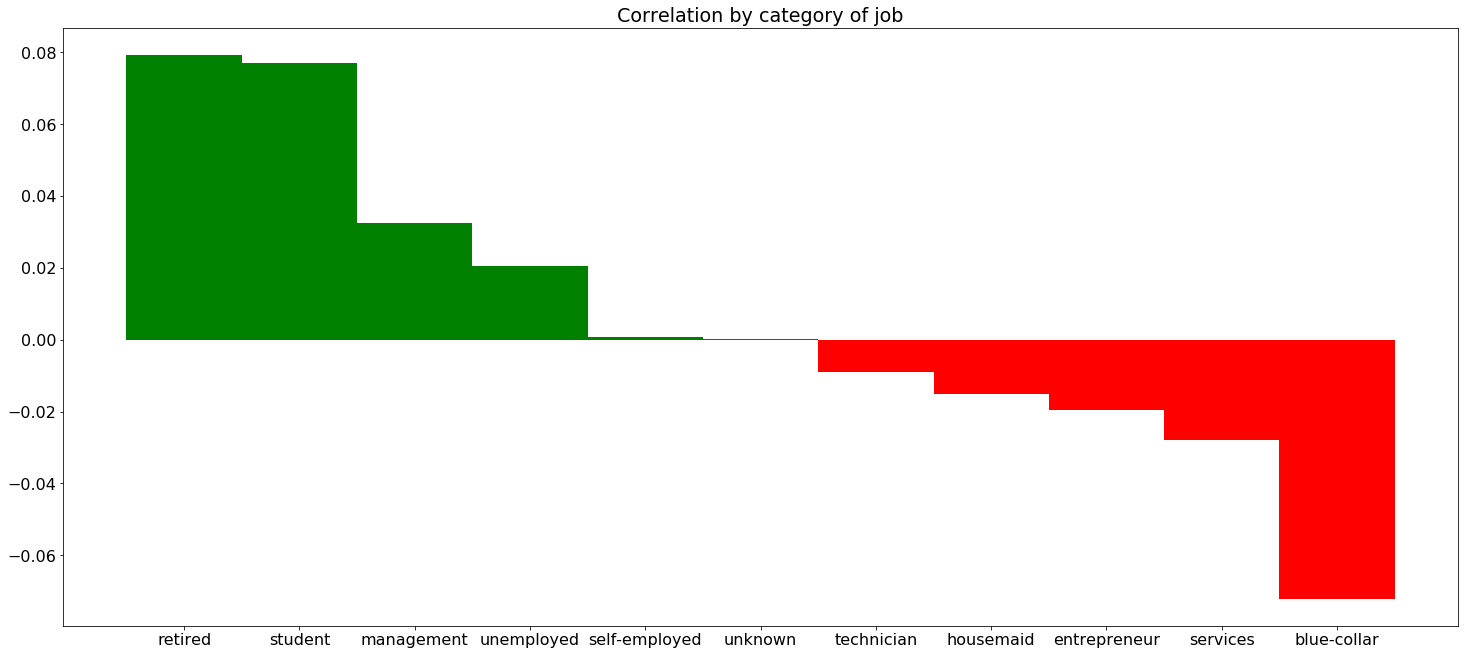

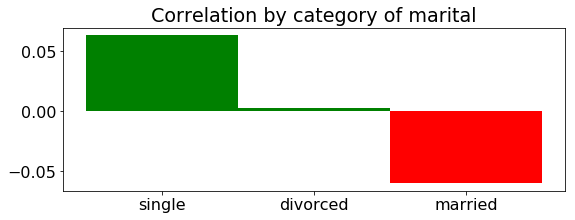

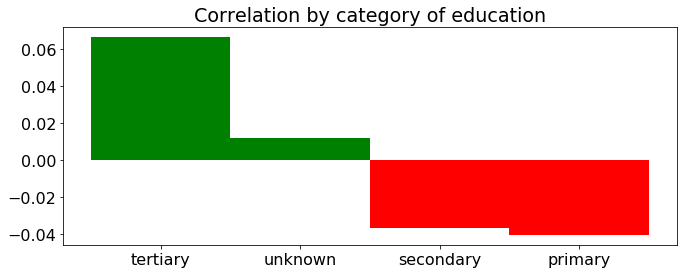

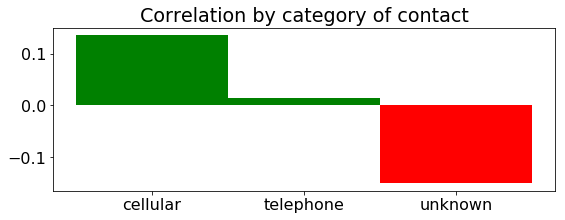

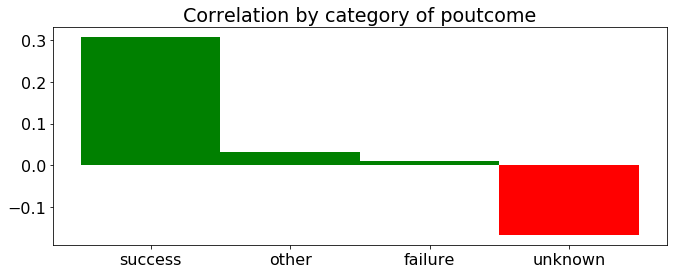

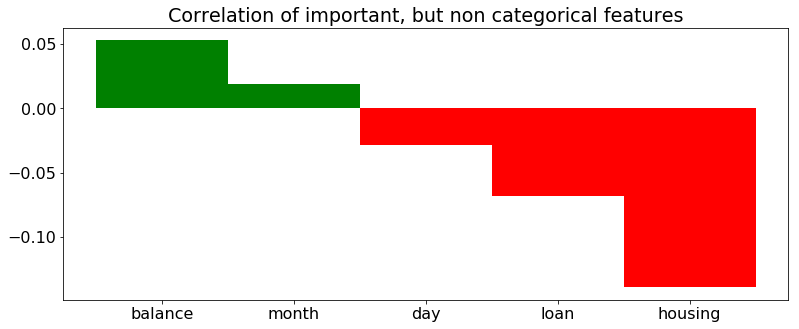

In [14]:
otherData = []
otherLabels = []
print('Correlation of features ranked as important by the model:')
for field in correlations.keys():
    if isinstance(correlations[field],dict):
        proc.bar(field,[c for c in correlations[field].values()],correlations[field].keys(),figureCount)
        figureCount+=1
    else:
        otherData.append(correlations[field])
        otherLabels.append(field)

proc.bar('',otherData,otherLabels,figureCount,isCategorical=False)
figureCount+=1




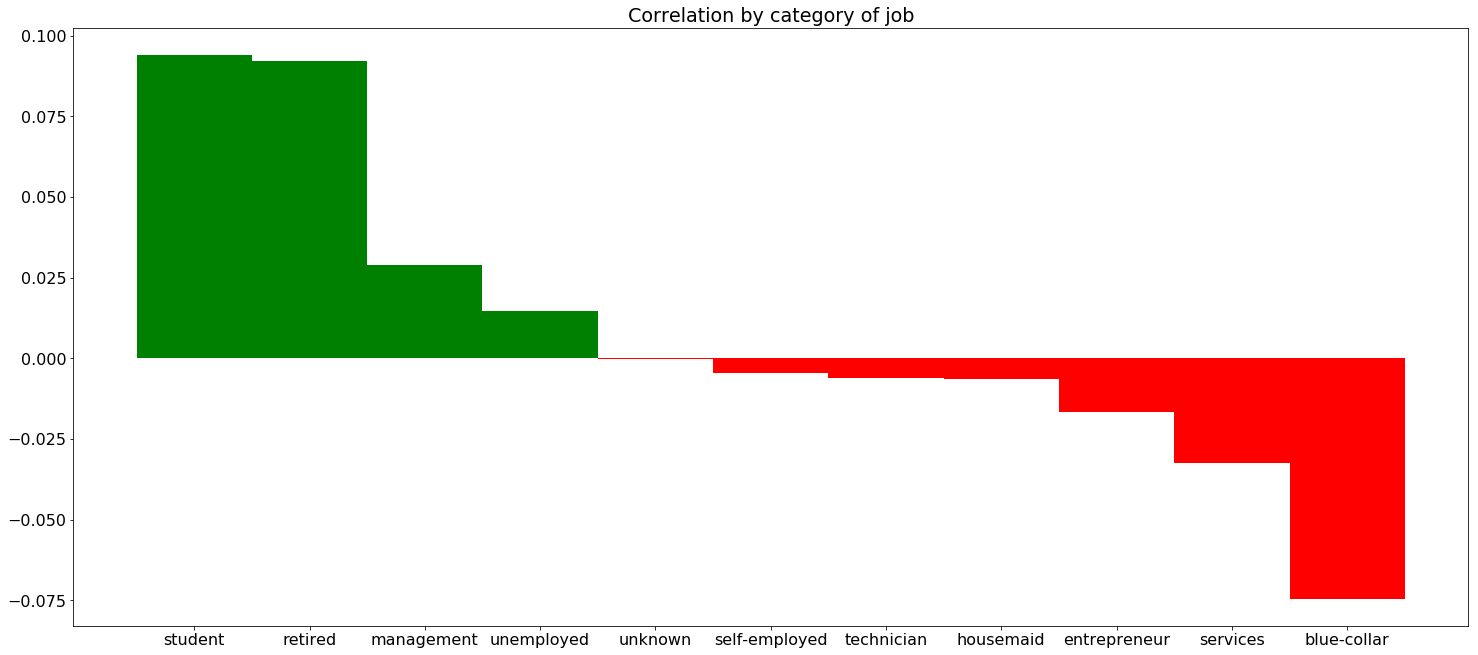

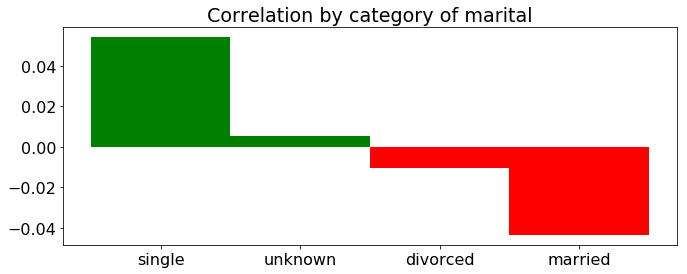

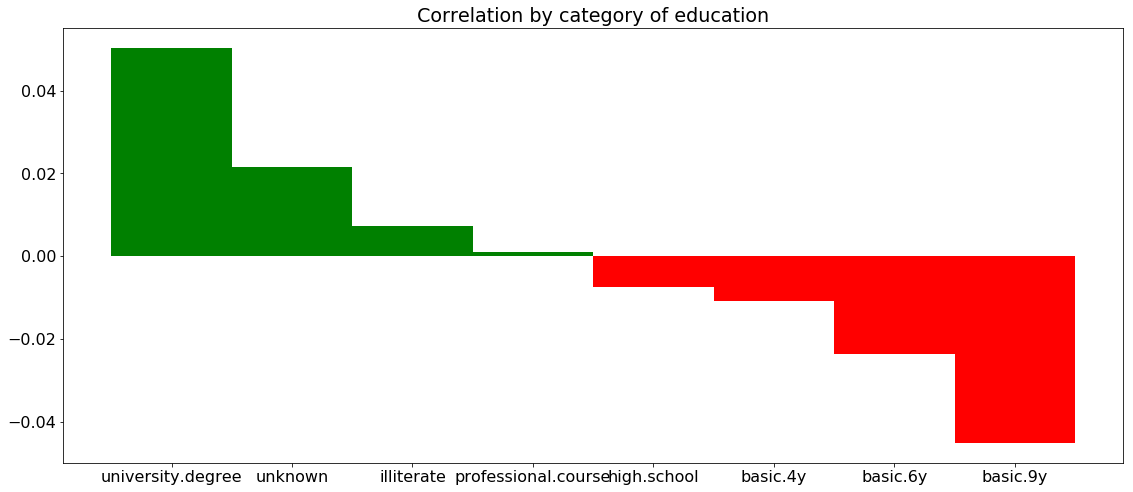

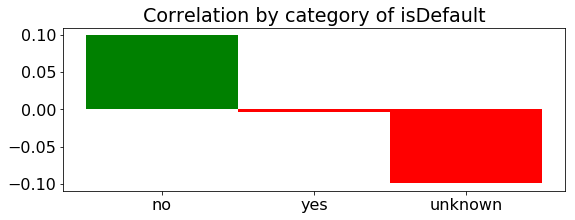

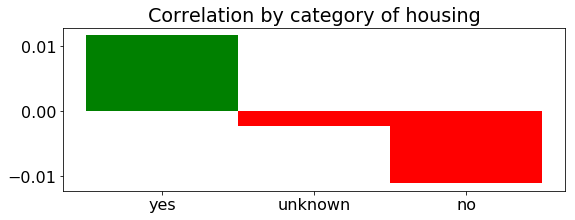

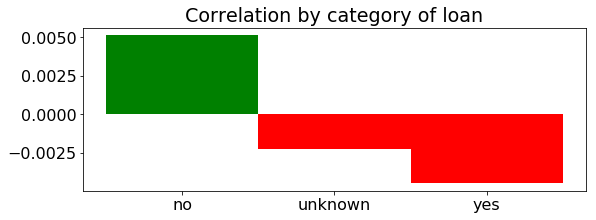

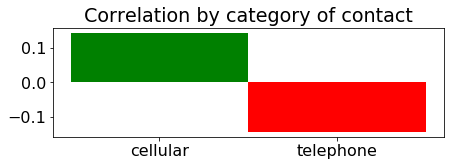

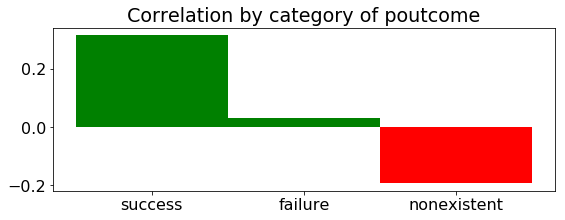

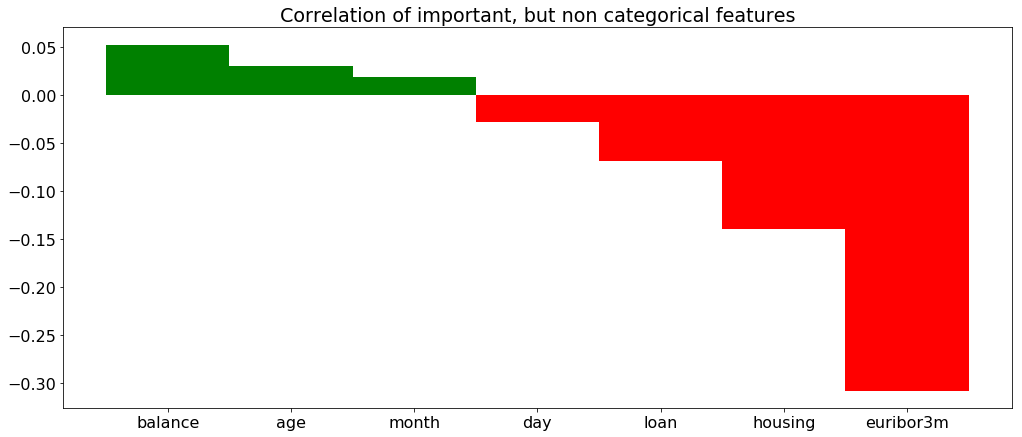

In [17]:

for field in correlationsA.keys():
    if isinstance(correlationsA[field],dict):
        proc.bar(field,[c for c in correlationsA[field].values()],correlationsA[field].keys(),figureCount)
        figureCount+=1
    else:
        otherData.append(correlationsA[field])
        otherLabels.append(field)

proc.bar('',otherData,otherLabels,figureCount,isCategorical=False)
figureCount+=1